In [26]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import os
from sklearn.metrics import mean_squared_error

In [27]:
# Verifica si tienes una GPU disponible y configura el dispositivo.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo actual:", device)

Dispositivo actual: cuda


In [28]:
# Cargar datos
df = pd.read_pickle('./Datasets/df_BTCUSDT_4hs.pickle')
df.head()

,Date,Open,High,Low,Close,Volume,RSI,EMA20,EMA40,EMA60,fastk,fastd,macd_line,signal_line,upper,middle,lower
0,2019-11-01 01:00:00,9064.12,9137.00,9030.00,9099.00,4264.6483,47.83,9159.96,8932.27,8735.44,26.35,18.82,32.38,75.53,9265.45,9145.60,9025.75
1,2019-11-01 05:00:00,9099.43,9279.00,9088.88,9163.16,10698.3508,50.82,9160.26,8943.53,8749.47,74.15,33.50,30.94,66.61,9237.69,9135.44,9033.18
2,2019-11-01 09:00:00,9164.56,9248.51,9061.65,9082.43,10852.3561,47.16,9152.85,8950.31,8760.38,21.92,40.81,23.01,57.89,9183.77,9109.71,9035.66
3,2019-11-01 13:00:00,9082.43,9213.57,9060.00,9170.49,6294.9252,51.29,9154.53,8961.05,8773.83,100.00,65.36,23.57,51.03,9202.38,9115.64,9028.91
4,2019-11-01 17:00:00,9170.09,9277.16,9167.15,9231.61,6240.6922,53.97,9161.87,8974.25,8788.84,100.00,73.97,28.61,46.54,9256.74,9149.34,9041.94


In [29]:
df.columns[1::]

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'EMA20', 'EMA40',
       'EMA60', 'fastk', 'fastd', 'macd_line', 'signal_line', 'upper',
       'middle', 'lower'],
      dtype='object')

In [30]:
len(df.columns[1::])

16

Funciones

In [31]:
# Función para preparar los datos
def prepare_data(data, seq_length):
    sequences = []
    target = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length, :]
        label = data[i+seq_length, 3]  # Se asume que la columna 3 es 'Close'
        sequences.append(seq)
        target.append(label)

    # Convertir las listas a numpy arrays y luego a tensores de PyTorch
    sequences = np.array(sequences)
    target = np.array(target)
    return torch.tensor(sequences, dtype=torch.float32).cuda(), torch.tensor(target, dtype=torch.float32).view(-1, 1).cuda()

In [32]:
# Función para cargar un checkpoint si existe
def load_checkpoint():
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        #lista_loss.extend(checkpoint['lista_loss'])
        print(f"Loaded checkpoint from epoch {epoch}")
        return epoch
    else:
        print("No checkpoint found.")
        return 0

In [33]:
# Modificar la definición del modelo LSTM para ser más complejo
class ComplexLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        # Capa LSTM con múltiples capas apiladas
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True).cuda()

        # Capa completamente conectada
        self.linear = nn.Linear(hidden_layer_size, output_size).cuda()

    def forward(self, input_seq):
        # Inicializar las celdas ocultas
        h0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).cuda()
        c0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).cuda()

        # Propagación hacia adelante
        lstm_out, _ = self.lstm(input_seq, (h0, c0))
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

***

In [34]:
data = df[df.columns[1::]].values
data.shape

(8706, 16)

In [35]:
seq_length = 10
sequences = []
target = []
for i in range(len(data) - seq_length):
    seq = data[i:i+seq_length, :]
    label = data[i+seq_length, 3]  # Se asume que la columna 3 es 'Close'
    sequences.append(seq)
    target.append(label)

# Convertir las listas a numpy arrays y luego a tensores de PyTorch
sequences = np.array(sequences)
#target = np.array(target)
#train_sequences = torch.tensor(sequences, dtype=torch.float32).cuda()
#train_target = torch.tensor(target, dtype=torch.float32).view(-1, 1).cuda()

In [36]:
sequences

array([[[ 9064.12,  9137.  ,  9030.  , ...,  9265.45,  9145.6 ,
          9025.75],
        [ 9099.43,  9279.  ,  9088.88, ...,  9237.69,  9135.44,
          9033.18],
        [ 9164.56,  9248.51,  9061.65, ...,  9183.77,  9109.71,
          9035.66],
        ...,
        [ 9213.97,  9255.  ,  9194.19, ...,  9270.46,  9218.78,
          9167.09],
        [ 9242.1 ,  9373.74,  9201.02, ...,  9326.6 ,  9249.55,
          9172.5 ],
        [ 9323.01,  9338.81,  9264.59, ...,  9356.22,  9266.41,
          9176.6 ]],

       [[ 9099.43,  9279.  ,  9088.88, ...,  9237.69,  9135.44,
          9033.18],
        [ 9164.56,  9248.51,  9061.65, ...,  9183.77,  9109.71,
          9035.66],
        [ 9082.43,  9213.57,  9060.  , ...,  9202.38,  9115.64,
          9028.91],
        ...,
        [ 9242.1 ,  9373.74,  9201.02, ...,  9326.6 ,  9249.55,
          9172.5 ],
        [ 9323.01,  9338.81,  9264.59, ...,  9356.22,  9266.41,
          9176.6 ],
        [ 9315.2 ,  9318.73,  9270.52, ...,  936

In [37]:
train_sequences.shape

NameError: name 'train_sequences' is not defined

In [38]:
train_sequences

NameError: name 'train_sequences' is not defined

CUDA

In [40]:
# Parámetros
seq_length = 10  # Longitud de la secuencia
train_size = 0.8  # Porcentaje de datos para entrenamiento

loss_function = nn.MSELoss()

# Normalizar los datos
data = df[df.columns[1::]].values
data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

inputs = data.shape[1]

# Dividir los datos en entrenamiento y evaluación
train_size = int(len(data) * train_size)
train_data = data[:train_size]
eval_data = data[train_size:]

# Preparar los datos
train_sequences, train_target = prepare_data(train_data, seq_length)
eval_sequences, eval_target = prepare_data(eval_data, seq_length)

# Mover datos de entrenamiento y evaluación a la GPU
train_sequences = train_sequences.cuda()
train_target = train_target.cuda()
eval_sequences = eval_sequences.cuda()
eval_target = eval_target.cuda()

# Inicializar el modelo con más capas LSTM
model = ComplexLSTM(input_size=inputs, hidden_layer_size=100, output_size=1, num_layers=5).to(device)

# Inicializar el optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

lista_loss = []
lista_mse = []
min_mse = 0.0001
# Ruta para guardar los checkpoints
checkpoint_path = 'checkpoints/save_BTC_4hs.pth'

# Cargar un posible checkpoint
start_epoch = load_checkpoint()

epochs = 300000

# Continuar entrenamiento desde el último epoch
for i in range(start_epoch, epochs+1):
    model.train()
    optimizer.zero_grad()
    
    y_pred = model(train_sequences)

    loss = loss_function(y_pred, train_target)
    loss.backward()
    optimizer.step()
    lista_loss.append(loss.item())

    model.eval()
    eval_predictions = model(eval_sequences.to('cuda'))
    eval_target_cpu = eval_target.to('cpu')
    mse = mean_squared_error(eval_target_cpu.detach().numpy(), eval_predictions.cpu().detach().numpy())
    mse_value = mse.item()
    lista_mse.append(mse_value)
    #print(f'Mean Squared Error (MSE): {mse}')

    if min_mse > mse:
        checkpoint = {
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lista_loss': lista_loss,
            'lista_mse' : lista_mse
            }
        torch.save(checkpoint, checkpoint_path)
        print(f'checkpoint save {mse} {i}')
        min_mse = mse

    if i % 1000 == 0:
        print(f'Epoch {i}, mse: {mse}')
    #    # Evaluación del modelo
    #    model.eval()
    #    eval_predictions = []
    #    with torch.no_grad():
    #        eval_predictions = model(eval_sequences)
    #    mse = mean_squared_error(eval_target.cpu(), eval_predictions.cpu())
    #    lista_mse.append(mse.item())
    #    print(f'Mean Squared Error (MSE): {mse}')
        
    # Guardar checkpoint cada 1000 epochs
    #if i % 1000 == 0  and i != 0:
    #    checkpoint = {
    #        'epoch': i,
    #        'model_state_dict': model.state_dict(),
    #        'optimizer_state_dict': optimizer.state_dict(),
    #        'lista_loss': lista_loss
    #    }
    #    torch.save(checkpoint, checkpoint_path)
    #    print('checkpoint save')

# Evaluación del modelo
model.eval()
eval_predictions = []
with torch.no_grad():
    eval_predictions = model(eval_sequences)

# Graficar los resultados
plt.figure(figsize=(28, 16))
plt.plot(eval_target.cpu(), label='True')
plt.plot(eval_predictions.cpu(), label='Predicted')
plt.legend()
plt.show()


No checkpoint found.
Epoch 0, mse: 0.13083834946155548
checkpoint save 9.910003427648917e-05 105
checkpoint save 9.385139856021851e-05 116
checkpoint save 8.51302538649179e-05 117
checkpoint save 7.936094334581867e-05 120
checkpoint save 7.726469630142674e-05 121
checkpoint save 7.533519237767905e-05 124
checkpoint save 7.457631727447733e-05 128
checkpoint save 7.333362736972049e-05 135
checkpoint save 7.147370342863724e-05 138
checkpoint save 7.121007365640253e-05 139
checkpoint save 6.942744221305475e-05 141
checkpoint save 6.830979691585526e-05 142
checkpoint save 6.785101868445054e-05 144
checkpoint save 6.660436338279396e-05 145
checkpoint save 6.624594243476167e-05 148
checkpoint save 6.531602411996573e-05 161
checkpoint save 6.520700117107481e-05 162
checkpoint save 6.514288543257862e-05 163
checkpoint save 6.437715637730435e-05 164
checkpoint save 6.40626167296432e-05 165
checkpoint save 6.366591696860269e-05 167
checkpoint save 6.338724051602185e-05 168
checkpoint save 6.31131

KeyboardInterrupt: 

***

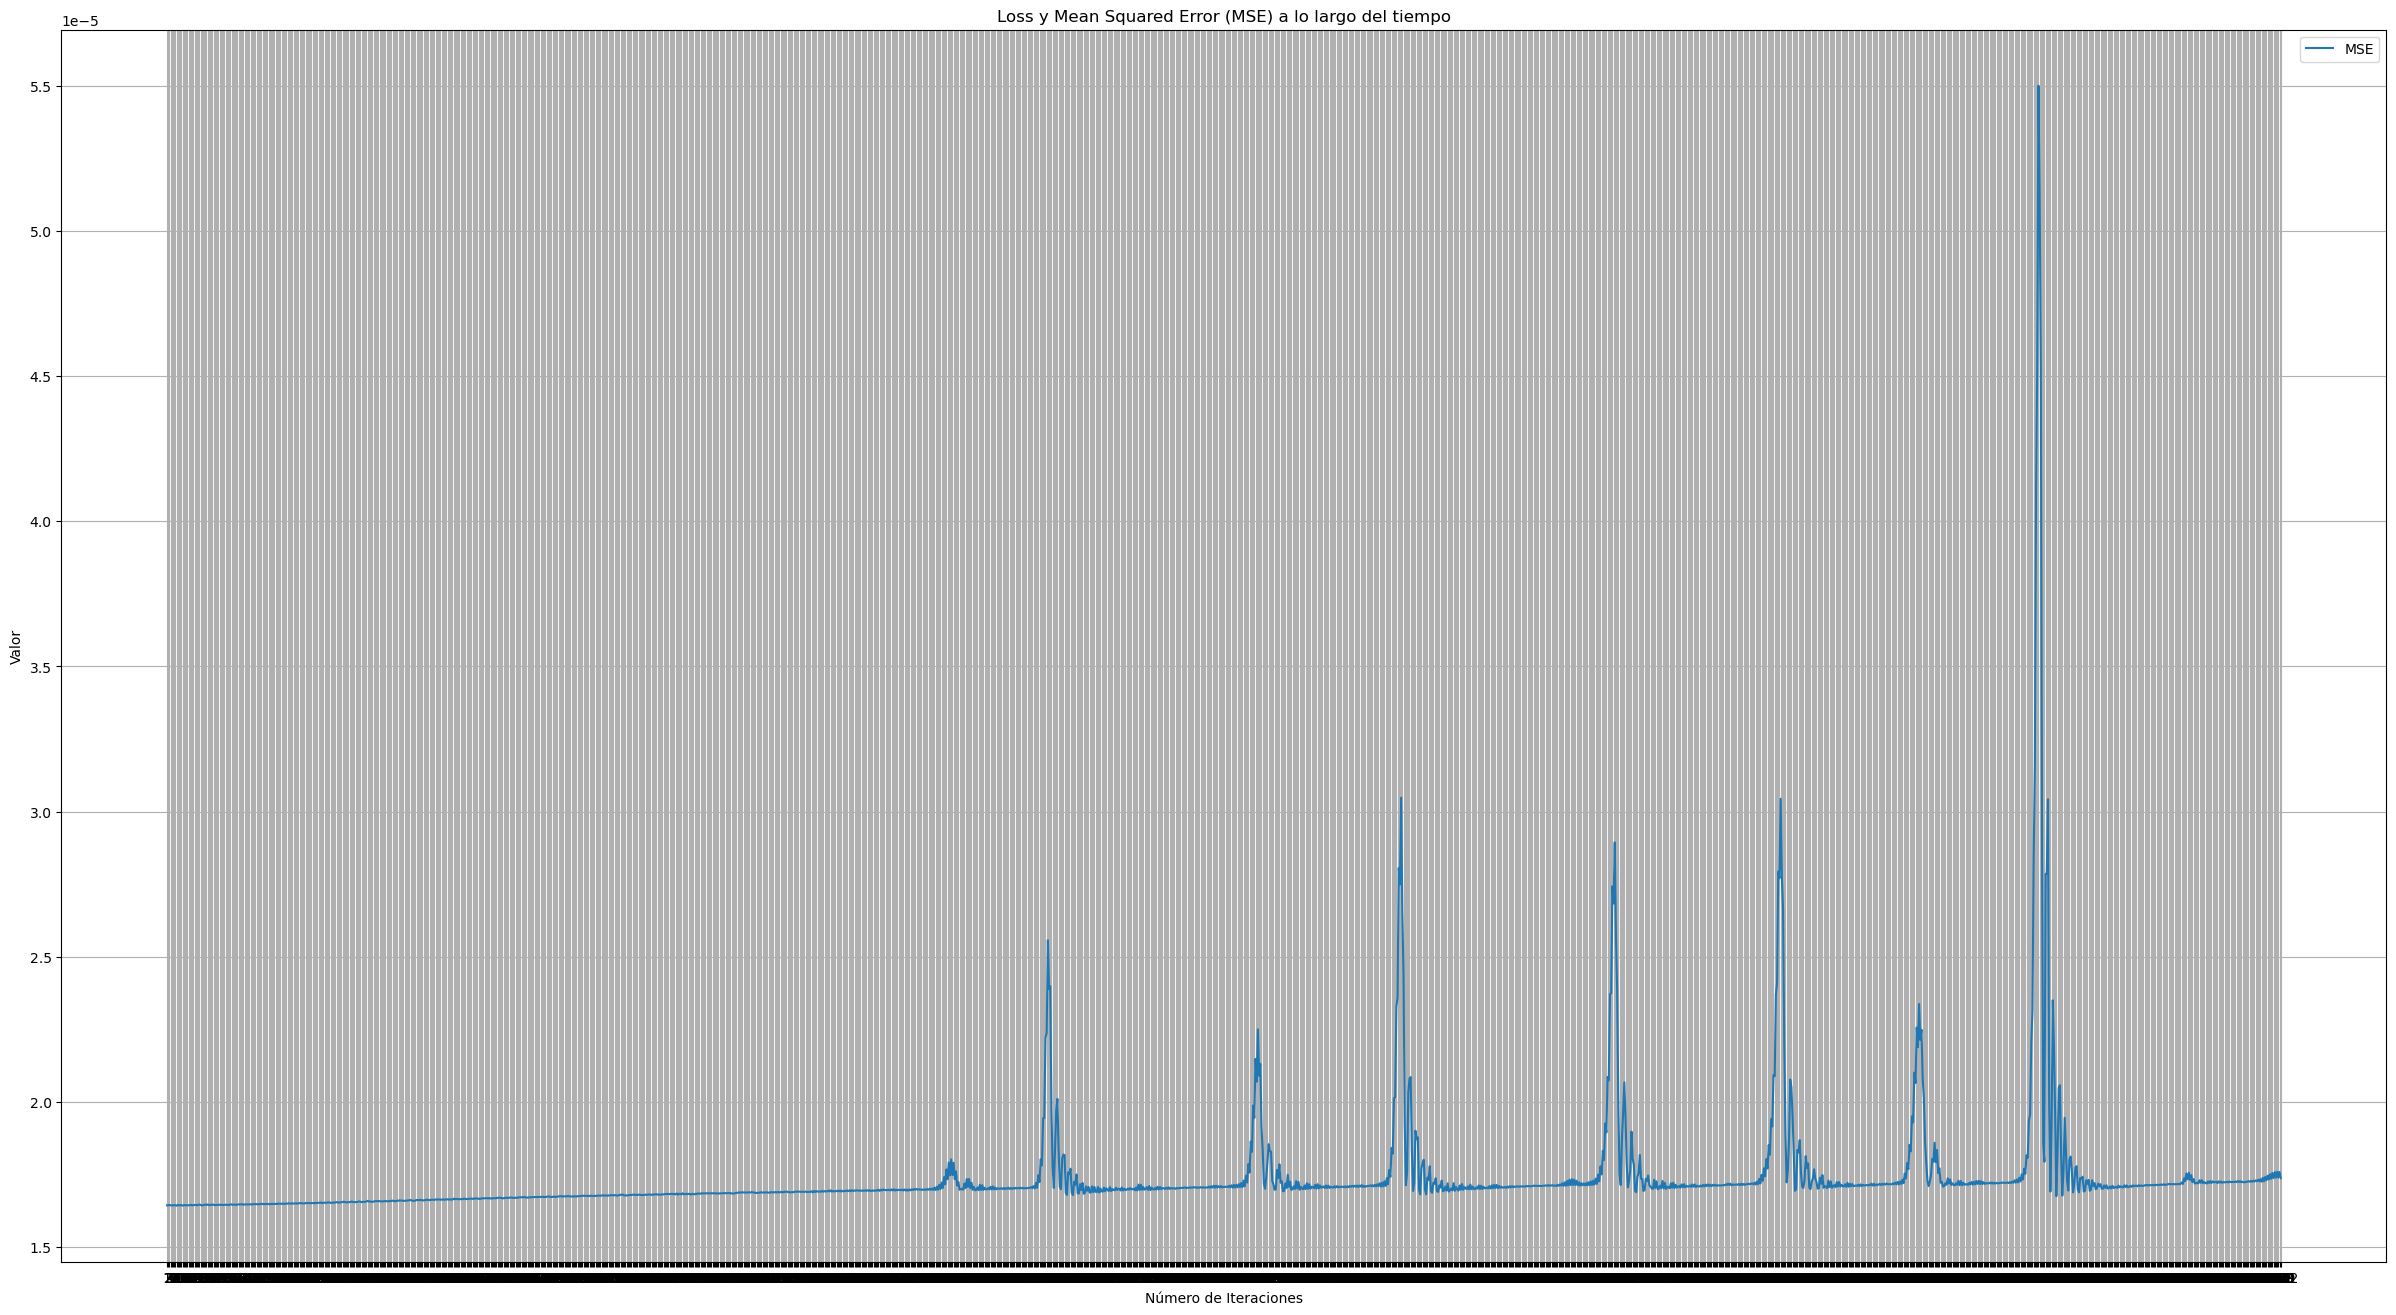

In [15]:
#temp_lista_loss = lista_loss[0:2000]
temp_lista_mse = lista_mse

# Crear una lista de índices para representar el tamaño de la lista
indices = list(range(1, len(temp_lista_mse) + 1))

# Establecer el tamaño de la figura
plt.figure(figsize=(30, 16))

# Trazar el gráfico
#plt.plot(indices, lista_loss, label='Loss')
plt.plot(indices, temp_lista_mse, label='MSE')

# Etiquetas y título
plt.xlabel('Número de Iteraciones')
plt.ylabel('Valor')
plt.title('Loss y Mean Squared Error (MSE) a lo largo del tiempo')
plt.legend()
plt.xticks(indices)
plt.grid(True)
plt.show()

In [16]:
lista_mse[0]

1.644101575948298e-05

In [17]:
type(lista_mse[0])

float

In [18]:
lista_mse.index(min(lista_mse))

8

In [90]:
mean_list = []
max = 1
for epoch in lista_loss:
    temp = lista_loss[:max]
    temp = sum(temp) / len(temp)
    mean_list.append(temp)
    max += 1

mean_list.index(min(mean_list))

99999

In [97]:
min(mean_list)

3.590393431873292e-05

In [19]:
# Crear una lista de índices para representar el tamaño de la lista
indices = list(range(1, len(mean_list) + 1))

# Establecer el tamaño de la figura
plt.figure(figsize=(30, 20))  # Ancho: 10 pulgadas, Alto: 6 pulgadas

# Trazar el gráfico
plt.plot(indices, mean_list, 'o-', label='Array con valor')

# Etiquetas y título
plt.xlabel('Tamaño de la lista')
plt.ylabel('Valor')
plt.title('loss')
plt.legend()
plt.xticks(indices)
plt.show()

NameError: name 'mean_list' is not defined

***

Evaluar nuevos datos

In [6]:
seq_length = 10

In [7]:
# Ruta para guardar los checkpoints
checkpoint_path = 'checkpoints/save_BTC_4hs.pth'

In [25]:
checkpoint = torch.load(checkpoint_path)
min(checkpoint['lista_mse'])

1.5960064047249034e-05

In [8]:
# Inicializar el modelo con más capas LSTM
model = ComplexLSTM(input_size=16, hidden_layer_size=100, output_size=1, num_layers=4).to(device)

# Inicializar el optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
load_checkpoint()

Loaded checkpoint from epoch 18459


In [10]:
# Cargar datos
df = pd.read_pickle('./Datasets/df_BTCUSDT_4hs.pickle')
df.head()

,Date,Open,High,Low,Close,Volume,RSI,EMA20,EMA40,EMA60,fastk,fastd,macd_line,signal_line,upper,middle,lower
0,2019-11-01 01:00:00,9064.12,9137.00,9030.00,9099.00,4264.6483,47.83,9159.96,8932.27,8735.44,26.35,18.82,32.38,75.53,9265.45,9145.60,9025.75
1,2019-11-01 05:00:00,9099.43,9279.00,9088.88,9163.16,10698.3508,50.82,9160.26,8943.53,8749.47,74.15,33.50,30.94,66.61,9237.69,9135.44,9033.18
2,2019-11-01 09:00:00,9164.56,9248.51,9061.65,9082.43,10852.3561,47.16,9152.85,8950.31,8760.38,21.92,40.81,23.01,57.89,9183.77,9109.71,9035.66
3,2019-11-01 13:00:00,9082.43,9213.57,9060.00,9170.49,6294.9252,51.29,9154.53,8961.05,8773.83,100.00,65.36,23.57,51.03,9202.38,9115.64,9028.91
4,2019-11-01 17:00:00,9170.09,9277.16,9167.15,9231.61,6240.6922,53.97,9161.87,8974.25,8788.84,100.00,73.97,28.61,46.54,9256.74,9149.34,9041.94


In [11]:
len(df)

8706

In [12]:
# Normalizar los datos
data = df[df.columns[1::]].values
data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

In [13]:
sequences, eval_target = prepare_data(data,seq_length)

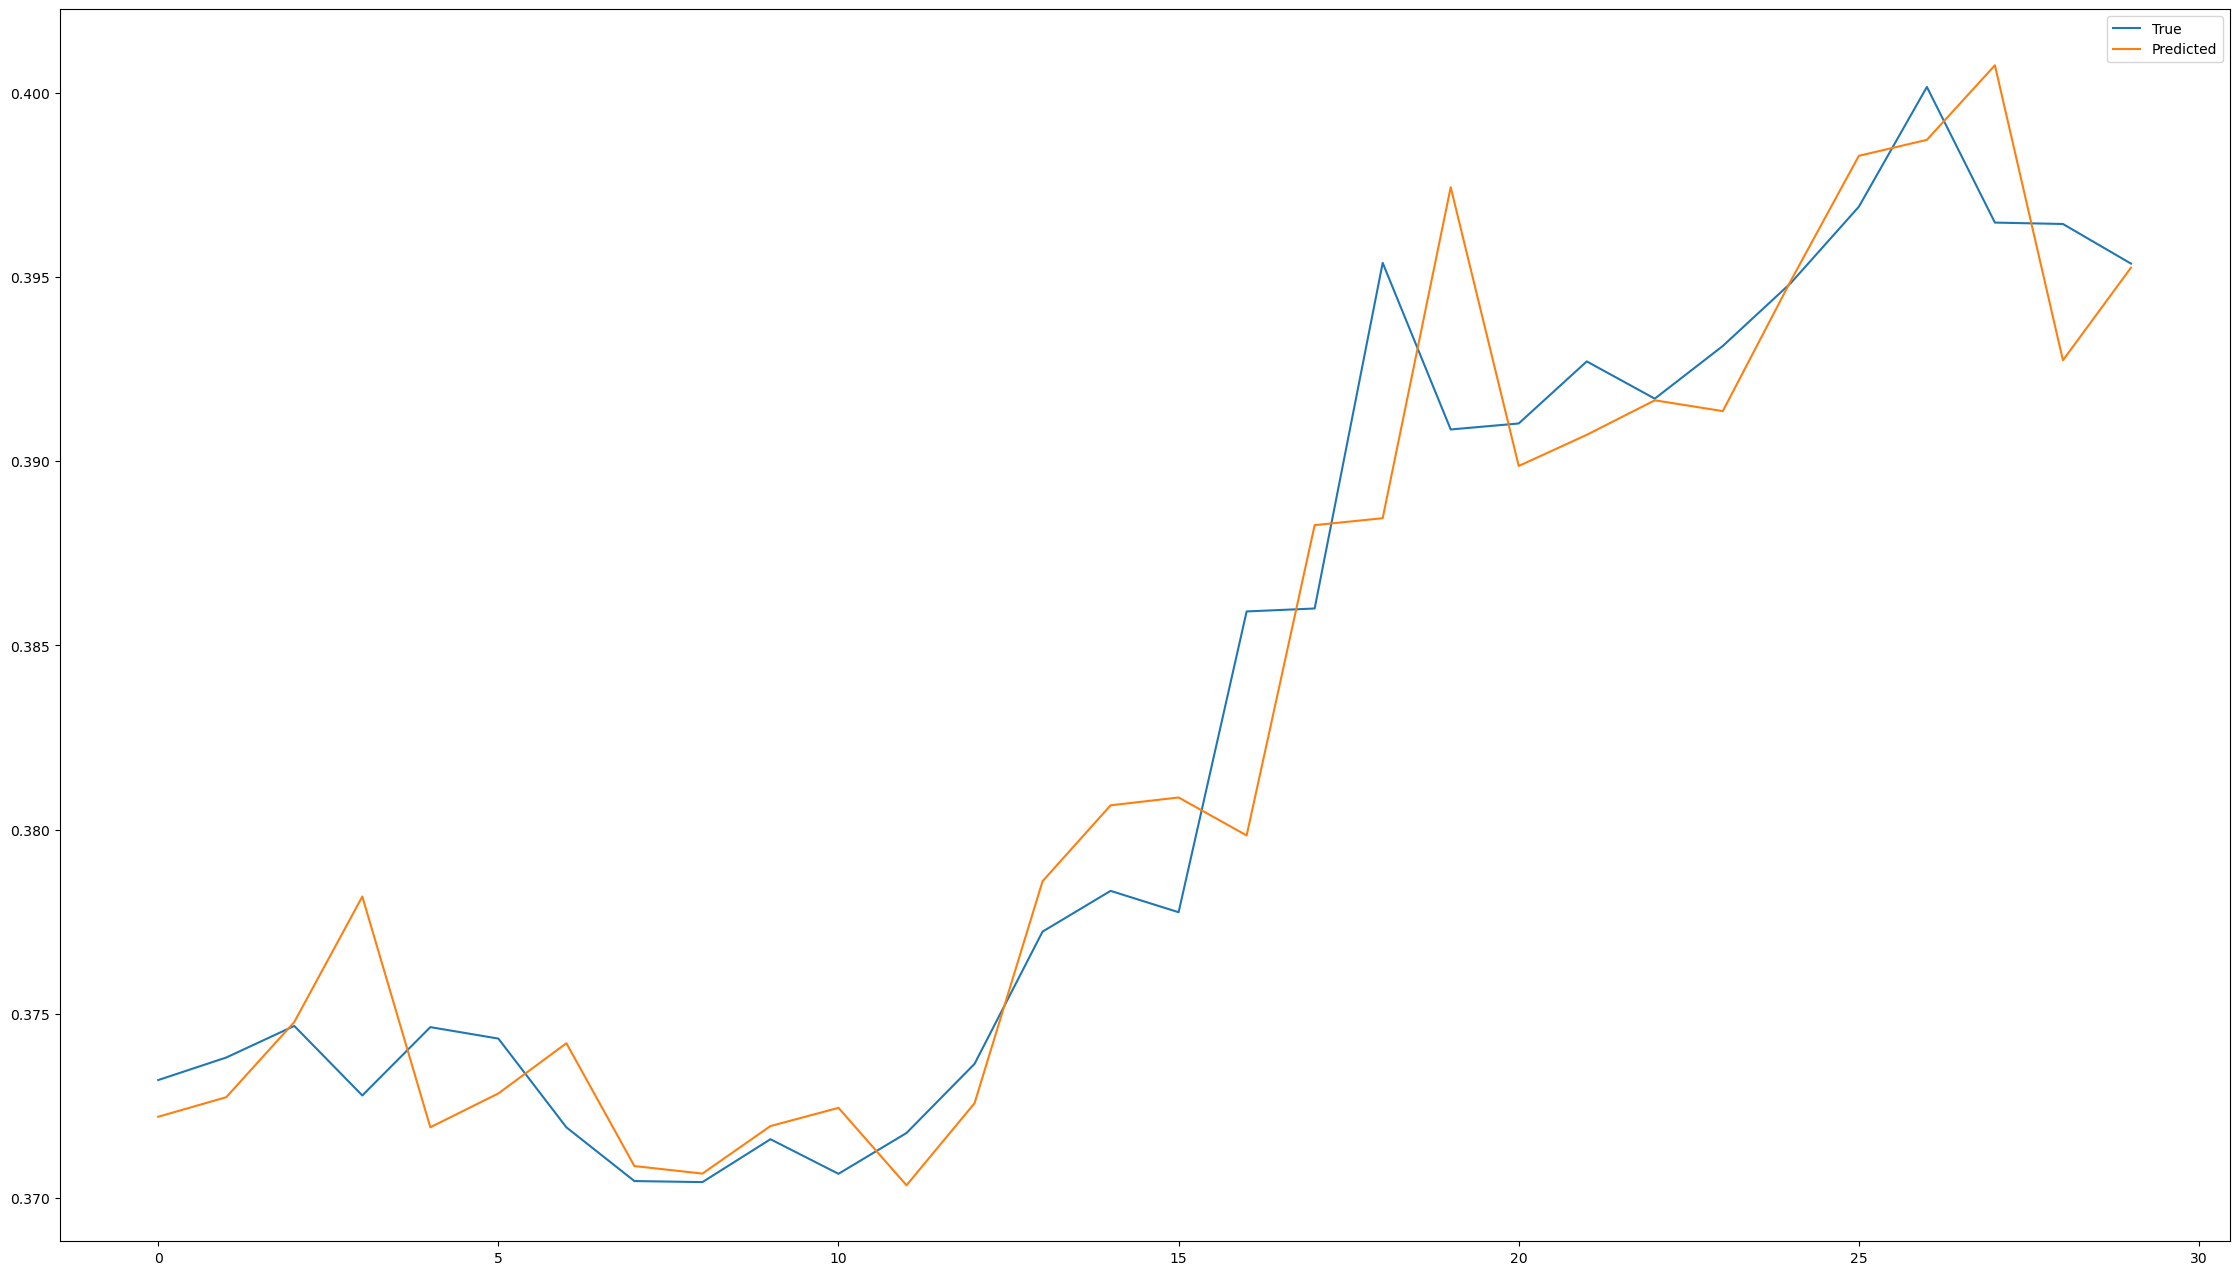

In [14]:
# Evaluación del modelo
model.eval()
eval_predictions = []
with torch.no_grad():
    eval_predictions = model(sequences)

# Graficar los resultados
plt.figure(figsize=(28, 16))
plt.plot(eval_target.cpu()[-30::], label='True')
plt.plot(eval_predictions.cpu()[-30::], label='Predicted')
plt.legend()
plt.show()

In [15]:
eval_predictions[-5::]

tensor([[0.3983],
        [0.3987],
        [0.4007],
        [0.3927],
        [0.3952]], device='cuda:0')

In [16]:
sequences

tensor([[[0.0704, 0.0654, 0.0822,  ..., 0.0620, 0.0677, 0.0742],
         [0.0709, 0.0676, 0.0831,  ..., 0.0616, 0.0676, 0.0743],
         [0.0719, 0.0671, 0.0827,  ..., 0.0608, 0.0672, 0.0744],
         ...,
         [0.0727, 0.0672, 0.0848,  ..., 0.0621, 0.0689, 0.0765],
         [0.0732, 0.0691, 0.0849,  ..., 0.0630, 0.0694, 0.0766],
         [0.0744, 0.0685, 0.0859,  ..., 0.0635, 0.0697, 0.0767]],

        [[0.0709, 0.0676, 0.0831,  ..., 0.0616, 0.0676, 0.0743],
         [0.0719, 0.0671, 0.0827,  ..., 0.0608, 0.0672, 0.0744],
         [0.0707, 0.0666, 0.0827,  ..., 0.0610, 0.0673, 0.0743],
         ...,
         [0.0732, 0.0691, 0.0849,  ..., 0.0630, 0.0694, 0.0766],
         [0.0744, 0.0685, 0.0859,  ..., 0.0635, 0.0697, 0.0767],
         [0.0743, 0.0682, 0.0860,  ..., 0.0636, 0.0698, 0.0769]],

        [[0.0719, 0.0671, 0.0827,  ..., 0.0608, 0.0672, 0.0744],
         [0.0707, 0.0666, 0.0827,  ..., 0.0610, 0.0673, 0.0743],
         [0.0720, 0.0676, 0.0843,  ..., 0.0619, 0.0678, 0.

In [17]:
sequences[0]

tensor([[0.0704, 0.0654, 0.0822, 0.0709, 0.0150, 0.4868, 0.0635, 0.0557, 0.0463,
         0.2635, 0.1882, 0.5344, 0.5476, 0.0620, 0.0677, 0.0742],
        [0.0709, 0.0676, 0.0831, 0.0719, 0.0376, 0.5210, 0.0635, 0.0559, 0.0466,
         0.7415, 0.3350, 0.5341, 0.5457, 0.0616, 0.0676, 0.0743],
        [0.0719, 0.0671, 0.0827, 0.0707, 0.0381, 0.4791, 0.0634, 0.0560, 0.0467,
         0.2192, 0.4081, 0.5326, 0.5438, 0.0608, 0.0672, 0.0744],
        [0.0707, 0.0666, 0.0827, 0.0720, 0.0221, 0.5264, 0.0634, 0.0562, 0.0470,
         1.0000, 0.6536, 0.5327, 0.5423, 0.0610, 0.0673, 0.0743],
        [0.0720, 0.0676, 0.0843, 0.0730, 0.0219, 0.5571, 0.0636, 0.0564, 0.0472,
         1.0000, 0.7397, 0.5336, 0.5413, 0.0619, 0.0678, 0.0745],
        [0.0730, 0.0675, 0.0850, 0.0731, 0.0173, 0.5598, 0.0637, 0.0566, 0.0475,
         1.0000, 1.0000, 0.5344, 0.5407, 0.0624, 0.0682, 0.0748],
        [0.0731, 0.0670, 0.0846, 0.0727, 0.0108, 0.5455, 0.0637, 0.0568, 0.0477,
         0.8222, 0.9407, 0.5346, 0.54

In [18]:
sequences[1]

tensor([[0.0709, 0.0676, 0.0831, 0.0719, 0.0376, 0.5210, 0.0635, 0.0559, 0.0466,
         0.7415, 0.3350, 0.5341, 0.5457, 0.0616, 0.0676, 0.0743],
        [0.0719, 0.0671, 0.0827, 0.0707, 0.0381, 0.4791, 0.0634, 0.0560, 0.0467,
         0.2192, 0.4081, 0.5326, 0.5438, 0.0608, 0.0672, 0.0744],
        [0.0707, 0.0666, 0.0827, 0.0720, 0.0221, 0.5264, 0.0634, 0.0562, 0.0470,
         1.0000, 0.6536, 0.5327, 0.5423, 0.0610, 0.0673, 0.0743],
        [0.0720, 0.0676, 0.0843, 0.0730, 0.0219, 0.5571, 0.0636, 0.0564, 0.0472,
         1.0000, 0.7397, 0.5336, 0.5413, 0.0619, 0.0678, 0.0745],
        [0.0730, 0.0675, 0.0850, 0.0731, 0.0173, 0.5598, 0.0637, 0.0566, 0.0475,
         1.0000, 1.0000, 0.5344, 0.5407, 0.0624, 0.0682, 0.0748],
        [0.0731, 0.0670, 0.0846, 0.0727, 0.0108, 0.5455, 0.0637, 0.0568, 0.0477,
         0.8222, 0.9407, 0.5346, 0.5403, 0.0626, 0.0684, 0.0750],
        [0.0727, 0.0672, 0.0848, 0.0731, 0.0141, 0.5610, 0.0638, 0.0570, 0.0480,
         1.0000, 0.9407, 0.5351, 0.54

***